# The goal
How to deal with tweets? Start with unsupervised unclassified data. What can you learn from unstructured Twitter data? Use unsupervised learning.

Ideally, we'd like to have a broad understanding of what the tweets were about. This is called topic modeling. 
Here we will use an algorithm called Latent Dirichlet Algorithm (LDA). Some intermediate steps are data cleaning and matching heterogeneous datasets. Ultimately this will lead to a more guided data understanding

In [1]:
%matplotlib inline

import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from collections import Counter
import operator
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import Pyro4

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import seaborn as sns

/Users/Peter/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# First load the data into a pandas dataframe

In [2]:
kagTweets = pd.read_csv('kaggleTweets.csv')

In [3]:
tweets = pd.read_csv('Tweets-CustomerSupport.csv', sep=';',index_col='id')
tweets = tweets.drop_duplicates('tweetId')
tweets.columns = ['account','from_handler','to_handler','message','time_stamp','tweet_id']

In [4]:
tweets = pd.read_csv('Tweets-CustomerSupport.csv', sep=';',index_col='id')

In [5]:
#Get rid of duplicate tweets
tweets.drop_duplicates('tweetId')
tweets.head()

,account,fromHandler,toHandler,message,timestamp,tweetId
id,,,,,,
1,@1ShirtSupport,@1ShirtSupport,@PissedOffBiotic,@PissedOffBiotic You got it! Just email us you...,01/18/2016 05:09:13,688951251455754241
2,@1ShirtSupport,@1ShirtSupport,@LordEstevez,@LordEstevez Thanks for the info! Well check o...,01/18/2016 02:38:39,688913360679653376
3,@1ShirtSupport,@1ShirtSupport,@LordEstevez,@LordEstevez Just want to make sure we have al...,01/18/2016 02:15:10,688907453212184576
4,@1ShirtSupport,@1ShirtSupport,@LordEstevez,@LordEstevez found it! It actually shows up as...,01/18/2016 02:14:24,688907258206367744
5,@1ShirtSupport,@1ShirtSupport,@LightingAshley,@LightingAshley It should be just about to be ...,01/18/2016 01:39:32,688898486025060352


In [6]:
list(np.unique(tweets.account))

['@1ShirtSupport',
 '@Airbnb',
 '@AmazonHelp',
 '@AskAmex',
 '@Avis',
 '@BCBSIL',
 '@GoDaddyHelp',
 '@Hootsuite_Help',
 '@InstapaperHelp',
 '@JetBlue',
 '@Kohls',
 '@MasterCard',
 '@MicrosoftHelps',
 '@TmobileHelp',
 '@americanair',
 '@fedexhelp',
 '@nikestore',
 '@schuh',
 '@verizon']

In [7]:
def getToFromTweets(userAccount,toTweet=True):
    """Function to print the number of tweets from a given account"""
    if toTweet==True:
        toFrom = 'toHandler'
    else:
        toFrom = 'fromHandler'
    tweetNum = str(np.sum(tweets[toFrom]==userAccount))
    #tweetNum = str(np.sum(tweets['toHandler']==userAccount))
    if toTweet==True:
        print 'Tweets to %s: %s' % (userAccount, tweetNum)
    else:
        print 'Tweets from %s: %s' % (userAccount, tweetNum)

In [8]:
for i in list(np.unique(tweets.account)):
    getToFromTweets(i,False)

Tweets from @1ShirtSupport: 3204
Tweets from @Airbnb: 3202
Tweets from @AmazonHelp: 3216
Tweets from @AskAmex: 3201
Tweets from @Avis: 3219
Tweets from @BCBSIL: 3233
Tweets from @GoDaddyHelp: 3238
Tweets from @Hootsuite_Help: 3240
Tweets from @InstapaperHelp: 3229
Tweets from @JetBlue: 3200
Tweets from @Kohls: 3207
Tweets from @MasterCard: 3205
Tweets from @MicrosoftHelps: 3211
Tweets from @TmobileHelp: 0
Tweets from @americanair: 0
Tweets from @fedexhelp: 0
Tweets from @nikestore: 3204
Tweets from @schuh: 3231
Tweets from @verizon: 3243


In [9]:
for i in list(np.unique(tweets.account)):
    getToFromTweets(i,True)

Tweets to @1ShirtSupport: 532
Tweets to @Airbnb: 23
Tweets to @AmazonHelp: 2991
Tweets to @AskAmex: 43
Tweets to @Avis: 360
Tweets to @BCBSIL: 78
Tweets to @GoDaddyHelp: 526
Tweets to @Hootsuite_Help: 180
Tweets to @InstapaperHelp: 38
Tweets to @JetBlue: 75
Tweets to @Kohls: 681
Tweets to @MasterCard: 38
Tweets to @MicrosoftHelps: 653
Tweets to @TmobileHelp: 0
Tweets to @americanair: 0
Tweets to @fedexhelp: 0
Tweets to @nikestore: 6295
Tweets to @schuh: 495
Tweets to @verizon: 71


In [10]:
companyList = list(np.unique(tweets.account))
companyList.append('@TMobileHelp')
companyList.append('@AmericanAir')
companyList.append('@FedExHelp')

#companyList
#list(np.unique(tweets.fromHandler))

In [11]:
usrIdx = tweets['fromHandler'].isin(companyList)
usrTweets = tweets[~usrIdx]
compTweets = tweets[usrIdx]
#tweets[tweets['fromHandler'].isin(list(np.unique(tweets.account)))]

In [12]:
#verTweets = tweets[tweets.fromHandler=='@verizon']

# Gensim code

In [13]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim import corpora, models
from gensim.similarities import MatrixSimilarity
from gensim.utils import SaveLoad
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import timeit
from re import sub
import pyLDAvis.gensim
from collections import Counter
from gensim.matutils import corpus2csc, sparse2full, corpus2dense
from wordcloud import WordCloud
from sklearn.utils import resample



In [18]:
#Functions for data cleaning

wnl = WordNetLemmatizer()

def removePunc(myWord):
    """Function to remove punctuation from string inputs"""
    if myWord is None:
        return myWord
    else:
        return sub('[.:;()/!&-*@$,?^\d+]','',myWord)
        
def removeAscii(myWord):
    """Function to remove ascii from string input"""
    if myWord is None:
        return myWord
    else:
        return str(sub(r'[^\x00-\x7F]+','', myWord.decode('utf-8').strip()))

def lemmatize(myWord):
    """Function to lemmatize words"""
    if myWord is None:
        return myWord
    else:
        return wnl.lemmatize(myWord)

def removeStopWords(myWord):
    """Function to remove stop words"""
    if myWord is None:
        return myWord
    if myWord not in str(stopwords.words('english')):
        return myWord

def removeLinkUser(myWord):
    """Function to remove web addresses and twitter handles"""
    if not myWord.startswith('@') and not myWord.startswith('http'):
        return myWord

def prepText(myWord):
    """Final text pre-processing function"""
    return removeStopWords(
        lemmatize(
            removeAscii(
                removePunc(
                    removeLinkUser(
                        myWord.lower()
                    )
                )
            )
        )
    )


In [19]:
# Function to clean/filter all tweets

def filterTweetList(tweetList):
    """Remove stop words, lemmatize, and clean all tweets"""
    return [[prepText(word) for word
                in tweet.split()
                    if prepText(word) is not None]
                for tweet in tweetList]
cleanedTweetList = filterTweetList(tweets['message'])

In [20]:
def makeDict(myTweetList):
    """Create dictionary from list of tokenized documents"""
    return corpora.Dictionary(myTweetList)

def makeCorpus(myTweetList,myDict):
    """Create corpus from list of tokenized documents"""
    return [myDict.doc2bow(tweet) for tweet in myTweetList]

def createLDA(myCorpus, myDictionary,myTopics=50,myPasses=10,myIterations=50,myAlpha=0.001):
    """LDA model call function"""
    return models.LdaMulticore(myCorpus, id2word=myDictionary, num_topics=myTopics, passes=myPasses,
    iterations=myIterations,alpha=myAlpha)

#lsi = models.LsiModel(myCorpus, id2word=myDict, num_topics=50)
# lsi has lower accuracy than lda

In [21]:
myDict = makeDict(cleanedTweetList)
myCorpus = makeCorpus(cleanedTweetList, myDict)
myLda = createLDA(myCorpus, myDict)

In [22]:
myLda = createLDA(myCorpus, myDict)

In [23]:
# turn on automatic rendering of visualizations
pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(myLda, myCorpus, myDict)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
9      6.536636        1       1 -0.293345  0.076160
3      3.936557        1       2 -0.179092 -0.075232
17     3.029565        1       3 -0.135779  0.059631
39     2.975750        1       4 -0.032891  0.136720
1      2.676671        1       5 -0.225574 -0.008217
13     2.565163        1       6 -0.145070  0.050210
7      2.524912        1       7 -0.129629 -0.061627
2      2.511168        1       8  0.006213 -0.113915
29     2.429929        1       9 -0.028246  0.077741
33     2.393604        1      10  0.105257  0.059538
35     2.247537        1      11 -0.115469  0.121120
42     2.243056        1      12 -0.021111 -0.196720
23     2.233511        1      13  0.050522 -0.061160
49     2.229949        1      14 -0.045697 -0.093166
44     2.208860        1      15 -0.133219  0.058074
36     2.200468        1      16  0.058383  0.090307
12     2.194445        1      17 -0.040086 -0.096930
32     2.179563        1      18 -0.009704  0.050125
8      2.146063        1      19 -0.123486  0.008738
6      2.108990        1      20  0.050220  0.126655
26     2.089215        1      21  0.049679 -0.061500
48     1.963044        1      22  0.037918 -0.060417
34     1.943934        1      23  0.047841 -0.113175
30     1.926982        1      24  0.067751 -0.103886
46     1.912677        1      25  0.030658 -0.000684
47     1.898027        1      26  0.102166  0.017937
37     1.897787        1      27  0.087991  0.022108
25     1.895987        1      28  0.024864 -0.140276
4      1.771340        1      29 -0.043033 -0.096693
15     1.576443        1      30  0.067052 -0.008683
19     1.568556        1      31  0.012305 -0.045443
0      1.543003        1      32  0.111685  0.035009
18     1.530072        1      33  0.094151  0.121605
11     1.521865        1      34  0.002376 -0.053000
20     1.520757        1      35  0.131127  0.024949
21     1.507396        1      36  0.094028  0.056600
27     1.484937        1      37  0.005673  0.076862
5      1.451463        1      38  0.037451 -0.141807
24     1.376180        1      39  0.049471 -0.065372
38     1.375295        1      40  0.078717 -0.056970
10     1.373213        1      41  0.071753  0.025927
22     1.367084        1      42  0.004470 -0.060302
14     1.337681        1      43 -0.039761  0.048711
43     1.323931        1      44 -0.032820  0.054299
16     1.319034        1      45 -0.022335  0.099006
28     1.243872        1      46  0.101996  0.034509
41     1.198030        1      47  0.093405  0.074046
31     1.188609        1      48 -0.065322 -0.016707
45     1.178895        1      49  0.118442  0.110138
40     1.142291        1      50  0.068105  0.015158, topic_info=      Category         Freq        Term  Total  loglift  logprob
3437   Default  6315.000000       sorry   6315  30.0000  30.0000
8766   Default  8128.000000          dm   8128  29.0000  29.0000
8169   Default  5271.000000         let   5271  28.0000  28.0000
27790  Default  5192.000000        know   5192  27.0000  27.0000
26527  Default  3876.000000       check   3876  26.0000  26.0000
7446   Default  3373.000000        take   3373  25.0000  25.0000
7222   Default  3736.000000       happy   3736  24.0000  24.0000
12524  Default  3543.000000        hear   3543  23.0000  23.0000
21274  Default  3687.000000        time   3687  22.0000  22.0000
24917  Default  2914.000000       thank   2914  21.0000  21.0000
22807  Default  2777.000000       youre   2777  20.0000  20.0000
26197  Default  3430.000000       phone   3430  19.0000  19.0000
7861   Default  4001.000000      number   4001  18.0000  18.0000
22221  Default  2835.000000       great   2835  17.0000  17.0000
8375   Default  3390.000000       email   3390  16.0000  16.0000
25481  Default  9713.000000      please   9713  15.0000  15.0000
24061  Default  2591.000000        need   2591  14.0000  14.0000
16694  Default  2531.000000    

## Clean the data, build the dict and corpus, and call the LDA model

In [24]:
cleanedUsrTweetList = filterTweetList(usrTweets['message'])
usrDict   = makeDict(cleanedUsrTweetList)
usrCorpus = makeCorpus(cleanedUsrTweetList, usrDict)
usrLda = createLDA(usrCorpus, usrDict)

In [25]:
pyLDAvis.gensim.prepare(usrLda, usrCorpus, usrDict)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
3      3.428676        1       1  0.234300 -0.224696
13     3.378633        1       2  0.169699 -0.267438
33     3.008504        1       3 -0.193582 -0.077421
1      2.904792        1       4 -0.099621  0.012753
36     2.671466        1       5 -0.157375 -0.059099
47     2.570337        1       6 -0.086784 -0.008879
2      2.564312        1       7 -0.164508 -0.059221
17     2.534438        1       8  0.201621 -0.134330
29     2.497865        1       9 -0.125110 -0.004682
12     2.491700        1      10  0.127907  0.059582
35     2.371818        1      11 -0.154422 -0.050272
48     2.363924        1      12 -0.099994 -0.043168
26     2.350266        1      13  0.114934  0.095834
40     2.325835        1      14 -0.109883 -0.127498
8      2.234091        1      15 -0.156806 -0.059547
10     2.232354        1      16 -0.135271 -0.006638
25     2.226179        1      17 -0.090463  0.009961
7      2.215141        1      18  0.055866  0.060375
45     2.197811        1      19  0.014833  0.038652
20     2.184594        1      20 -0.123567 -0.022636
6      2.065443        1      21  0.168531 -0.070511
49     2.018426        1      22 -0.034481  0.048951
0      2.010554        1      23  0.089499  0.062628
27     1.970266        1      24 -0.086624 -0.011025
28     1.954081        1      25  0.149022 -0.103627
21     1.927567        1      26 -0.050918 -0.001148
11     1.902413        1      27  0.033894  0.061993
15     1.897821        1      28 -0.071492 -0.002625
19     1.894473        1      29 -0.003902  0.005446
37     1.781338        1      30 -0.074160  0.004283
18     1.779364        1      31 -0.047592  0.006742
38     1.774215        1      32  0.101967  0.137557
23     1.752309        1      33  0.022702  0.046097
43     1.646383        1      34 -0.035529 -0.000840
24     1.621018        1      35  0.016160  0.044113
44     1.607984        1      36  0.084675  0.004847
4      1.584612        1      37 -0.080448  0.016003
22     1.574497        1      38 -0.060425 -0.009438
46     1.572717        1      39  0.067390 -0.070683
30     1.559150        1      40  0.063005  0.057091
39     1.520849        1      41 -0.027138 -0.009774
34     1.442662        1      42  0.006395  0.088295
42     1.404738        1      43  0.106979  0.076516
14     1.384148        1      44  0.080354  0.094707
31     1.367657        1      45  0.114838  0.021291
41     1.313171        1      46  0.030921  0.074679
5      1.296807        1      47  0.067176  0.112474
32     1.291737        1      48  0.063898  0.081808
9      1.175768        1      49 -0.016226  0.066997
16     1.155098        1      50  0.099753  0.035521, topic_info=      Category         Freq          Term  Total  loglift  logprob
4340   Default  1682.000000           air   1682  30.0000  30.0000
1267   Default   897.000000           one    897  29.0000  29.0000
926    Default  1052.000000          time   1052  28.0000  28.0000
5935   Default  1140.000000        jordan   1140  27.0000  27.0000
11697  Default  1162.000000          nike   1162  26.0000  26.0000
4423   Default   897.000000        thanks    897  25.0000  25.0000
10000  Default   802.000000          back    802  24.0000  24.0000
11484  Default   592.000000             -    592  23.0000  23.0000
7029   Default   525.000000         thank    525  22.0000  22.0000
2199   Default   528.000000          kobe    528  21.0000  21.0000
1345   Default   447.000000          take    447  20.0000  20.0000
13180  Default   509.000000         style    509  19.0000  19.0000
355    Default   675.000000       service    675  18.0000  18.0000
4971   Default   426.000000          size    426  17.0000  17.0000
238    Default   424.000000            xi    424  16.0000  16.0000
11061  Default   445.000000       limited    445  15.0000  15.0000
6282   Default   476.000000          game    476  14.0000  14.

In [26]:
cleanCompTweetList = filterTweetList(compTweets['message'])
compDict   = makeDict(cleanCompTweetList)
compCorpus = makeCorpus(cleanCompTweetList, compDict)


In [27]:
compLda = createLDA(compCorpus, compDict)

In [28]:
pyLDAvis.gensim.prepare(compLda, compCorpus, compDict)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
13     6.379246        1       1  0.297263  0.074501
48     3.985583        1       2  0.094014  0.143123
15     3.847697        1       3  0.118797  0.108420
14     3.278381        1       4  0.268256  0.010382
7      3.003095        1       5 -0.059310  0.011172
36     2.821349        1       6 -0.026482 -0.091870
35     2.760327        1       7  0.140183 -0.004275
33     2.668570        1       8 -0.000830 -0.078545
29     2.607048        1       9 -0.092123  0.032074
23     2.472495        1      10 -0.054488 -0.066800
6      2.424403        1      11  0.178988  0.027863
5      2.360434        1      12  0.004055 -0.183161
19     2.314312        1      13  0.063074  0.201744
43     2.275256        1      14 -0.040037  0.043883
39     2.256769        1      15 -0.073995  0.121952
24     2.240434        1      16 -0.103233 -0.049839
47     2.171483        1      17  0.056757 -0.134566
28     1.982548        1      18 -0.004933 -0.213205
31     1.941668        1      19  0.171183  0.025719
27     1.927712        1      20 -0.116369 -0.057035
46     1.893107        1      21  0.157668  0.032801
18     1.888168        1      22 -0.113247 -0.009226
40     1.887141        1      23  0.171199 -0.063818
17     1.765395        1      24  0.097661 -0.039709
11     1.703540        1      25 -0.035246  0.094160
38     1.703013        1      26  0.069336 -0.012623
32     1.698902        1      27 -0.001551  0.030703
37     1.684914        1      28 -0.007554 -0.125666
34     1.681927        1      29  0.168864 -0.090024
26     1.613048        1      30 -0.118965  0.039074
16     1.572134        1      31 -0.004816  0.076883
30     1.564697        1      32 -0.129680  0.026054
25     1.522379        1      33 -0.069746  0.031885
41     1.487422        1      34  0.050736 -0.197773
0      1.459283        1      35 -0.093697  0.035590
22     1.450084        1      36  0.040941  0.134009
2      1.418313        1      37  0.026157 -0.046649
20     1.404921        1      38 -0.040516  0.052348
21     1.404191        1      39 -0.103394  0.086021
9      1.399406        1      40 -0.044837 -0.053774
8      1.329843        1      41 -0.047563 -0.088375
44     1.293596        1      42 -0.069452 -0.076569
4      1.289942        1      43 -0.101249  0.052953
45     1.275750        1      44 -0.077365  0.082203
42     1.204209        1      45 -0.096539 -0.007887
3      1.176812        1      46 -0.077212 -0.017782
10     1.170000        1      47 -0.016784  0.013923
49     1.125505        1      48 -0.143156  0.014396
12     1.113784        1      49 -0.109372  0.066006
1      1.099764        1      50 -0.101392  0.039328, topic_info=      Category         Freq           Term  Total  loglift  logprob
5928   Default  5005.000000         thanks   5005  30.0000  30.0000
19695  Default  4756.000000           know   4756  29.0000  29.0000
3855   Default  4961.000000            let   4961  28.0000  28.0000
1113   Default  3644.000000          happy   3644  27.0000  27.0000
16135  Default  3648.000000          check   3648  26.0000  26.0000
17835  Default  3810.000000         number   3810  25.0000  25.0000
5647   Default  7782.000000             dm   7782  24.0000  24.0000
10917  Default  2651.000000          youre   2651  23.0000  23.0000
1778   Default  2926.000000           take   2926  22.0000  22.0000
12141  Default  1990.000000         assist   1990  21.0000  21.0000
14708  Default  3096.000000           like   3096  20.0000  20.0000
1339   Default  2934.000000        address   2934  19.0000  19.0000
13211  Default  9170.000000         please   9170  18.0000  18.0000
11574  Default  2389.000000          thank   2389  17.0000  17.0000
4476   Default  3018.000000          email   3018  16.0000  16.0000
7782   Default  6523.000000           help   6523  15.0000  15.0000
14907  Default  2187.000000         detail   

In [29]:
kagTweets = pd.read_csv('kaggleTweets.csv')

In [30]:
cleanKagTweetList = filterTweetList(kagTweets['text'])
kagDict   = makeDict(cleanKagTweetList)
kagCorpus = makeCorpus(cleanKagTweetList, kagDict)
kagLda = createLDA(kagCorpus, kagDict)

In [136]:
#len(cleanKagTweetList[0])
Counter([len(tweet) for tweet in cleanKagTweetList])

Counter({0: 26,
         1: 404,
         2: 543,
         3: 730,
         4: 820,
         5: 872,
         6: 932,
         7: 1049,
         8: 1132,
         9: 1306,
         10: 1456,
         11: 1596,
         12: 1362,
         13: 1072,
         14: 712,
         15: 358,
         16: 168,
         17: 69,
         18: 22,
         19: 7,
         20: 3,
         21: 1})

In [251]:
#kagLda = createLDA(kagCorpus, kagDict)


In [103]:
ldaViz = pyLDAvis.gensim.prepare(kagLda, kagCorpus, kagDict)

In [104]:
ldaViz.plot_opts()

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
43     4.863204        1       1 -0.217131  0.110123
11     3.919435        1       2  0.162362  0.006647
15     3.556890        1       3 -0.097500 -0.112141
30     3.275066        1       4 -0.097969  0.152709
48     2.786144        1       5 -0.088332  0.148928
10     2.637285        1       6 -0.129438 -0.083498
28     2.595097        1       7 -0.074824 -0.186904
8      2.451986        1       8 -0.071265 -0.036302
45     2.436052        1       9 -0.098841  0.023151
37     2.420085        1      10 -0.125846 -0.018179
17     2.383661        1      11 -0.025140  0.172635
18     2.233858        1      12  0.048592 -0.020624
9      2.229052        1      13  0.049907 -0.088598
21     2.132641        1      14 -0.039796 -0.043180
13     2.091104        1      15  0.108033 -0.042968
2      2.090073        1      16 -0.075765  0.005730
47     2.043008        1      17 -0.017693 -0.000526
41     2.024434        1      18 -0.126196 -0.033681
25     1.939112        1      19 -0.005185 -0.000166
20     1.885727        1      20  0.057458 -0.003942
23     1.855205        1      21 -0.066475 -0.027684
16     1.851152        1      22  0.123010  0.006783
1      1.829990        1      23  0.097129 -0.000407
33     1.823795        1      24 -0.034077 -0.081206
14     1.784589        1      25  0.073096  0.085524
7      1.759415        1      26  0.048888  0.023509
39     1.738920        1      27 -0.003061 -0.017747
34     1.720693        1      28 -0.030323  0.046933
49     1.667468        1      29  0.139966  0.066548
0      1.661432        1      30  0.062485 -0.003084
19     1.655692        1      31  0.061855  0.056206
26     1.648602        1      32 -0.030421 -0.061213
38     1.645936        1      33  0.082197 -0.092613
6      1.645000        1      34  0.116791  0.032209
35     1.639052        1      35  0.050542 -0.017382
12     1.635857        1      36  0.082965 -0.061536
31     1.609049        1      37 -0.067829 -0.056175
22     1.580480        1      38  0.045724  0.042226
4      1.571987        1      39 -0.086490  0.026538
5      1.533143        1      40 -0.022125  0.005764
46     1.502467        1      41  0.017348 -0.019600
29     1.492518        1      42 -0.017237 -0.043245
3      1.477691        1      43  0.097339  0.040587
27     1.440481        1      44  0.066595 -0.047743
40     1.430740        1      45 -0.024330 -0.009605
24     1.426885        1      46  0.076260  0.025997
36     1.400650        1      47 -0.028576 -0.021227
42     1.397299        1      48  0.010724  0.100856
44     1.344029        1      49 -0.013470  0.092798
32     1.235869        1      50  0.036066 -0.041227, topic_info=      Category         Freq         Term  Total  loglift  logprob
7318   Default   601.000000        thank    601  30.0000  30.0000
322    Default   976.000000      service    976  29.0000  29.0000
3775   Default  1066.000000       thanks   1066  28.0000  28.0000
2550   Default   917.000000     customer    917  27.0000  27.0000
7674   Default  1048.000000    cancelled   1048  26.0000  26.0000
11646  Default  4494.000000       flight   4494  25.0000  25.0000
1277   Default   502.000000    flightled    502  24.0000  24.0000
8139   Default   423.000000         late    423  23.0000  23.0000
6725   Default   755.000000          bag    755  22.0000  22.0000
822    Default   344.000000       minute    344  21.0000  21.0000
10450  Default   216.000000      jetblue    216  20.0000  20.0000
8375   Default   555.000000       please    555  19.0000  19.0000
3163   Default   308.000000      problem    308  18.0000  18.0000
8870   Default   253.000000           dm    253  17.0000  17.0000
3762   Default   369.000000          min    369  16.0000  16.0000
11970  Default   362.000000      waiting    362  15.0000  15.0000
11148  Default   232.000000        worst    232  14.0000  14.0000
2499   Defaul

In [261]:
SaveLoad.save(kagLda,'kaggleLDAmodel')
corpora.MmCorpus.serialize('kaggleCorpus.mm', kagCorpus)
#corpora.dictionarydictio.save('/tmp/deerwester.dict')
kagDict.save('kaggleDictionary.dict')
#kagLda.show_topic(43)
#corpora.Dictionary.load()

In [258]:
SaveLoad.load('kaggleLDAmodel')

In [105]:
#list(testVis[0].index)
reIndex = pd.DataFrame(list(testVis[0].index),columns=['newIndex'])
#reIndex.sort

In [138]:
#kagLda.show_topic(11)

In [33]:
kagIndex = MatrixSimilarity(kagLda[kagCorpus]) # transform corpus to LSI space and index it
kagIndex.index.shape

(14640, 50)

In [34]:
# access the first topic
#len(kagIndex.index[0,:])
#kagLda.show_topic(0)

# Using `top_topics` maps lda topics to the visualization

In [109]:
def translateLdaIdx(myLdaModel, myLdaViz):
    """Translate lda model topics to match the topics in pyLDAvis visualization"""
    ldaVizIdx = myLdaViz[0].index
    return list(ldaVizIdx)

In [112]:
newIdx = translateLdaIdx(kagLda,ldaViz)

In [41]:
def createDenseMat(myLdaModel,myCorpus,newIdx):
    """Transform corpus to dataframe with topics matching lda visualization"""
    numTopics = myLdaModel.num_topics
    myDense = corpus2dense(myLdaModel[myCorpus],numTopics)
    myDf = pd.DataFrame(myDense)
    mySortedDf = myDf.transpose()
    mySortedDf = myDf.transpose()[newIdx]
    mySortedDf.columns = ['topic' + str(i + 1) for i in range(numTopics)]
    return mySortedDf

In [113]:
kagDf = createDenseMat(kagLda,kagCorpus,newIdx)

In [44]:
### Working
def sortByTopicToIdx(cleanedTweetList,mySortedDf,myTopic,myTopicThresh=0.1):
    """Returns an index of tweets surpassing a topic value threshold"""
    myCleanArray = np.array(cleanedTweetList)
    srtIdx = list(mySortedDf[mySortedDf[myTopic]>myTopicThresh].index)
    return srtIdx

In [45]:
# Next up sort the tweets
def sortTweetsByIdx(cleanedTweetList,srtIdx):
    """Returns sorted tweets as a list based on a defined sort index"""
    myCleanArray = np.array(cleanedTweetList)
    srtTweets = list(myCleanArray[srtIdx])
    return srtTweets

In [150]:
# Get sorted tweet list
sortedIdx = sortByTopicToIdx(cleanKagTweetList,kagDf,'topic2',myTopicThresh=0.2)
# get sorted tweet list
sortedTpx2 = sortTweetsByIdx(cleanKagTweetList,sortedIdx)

In [151]:
#sortedTpx1

In [152]:
def makeWordCloud(mySortedTweets):
    """Create word cloud of tweets passing filter"""
    filteredWords = ' '.join([' '.join(string) for string in mySortedTweets])
    #topicCloud = WordCloud(max_font_size=100,scale=8).generate(topicCloudWords)
    myTopicCloud = WordCloud(max_font_size=100,scale=8).generate(filteredWords)
    fig = plt.figure(figsize=(10,10), dpi=1600)
    plt.imshow(myTopicCloud)
    plt.axis("off")
    plt.show()

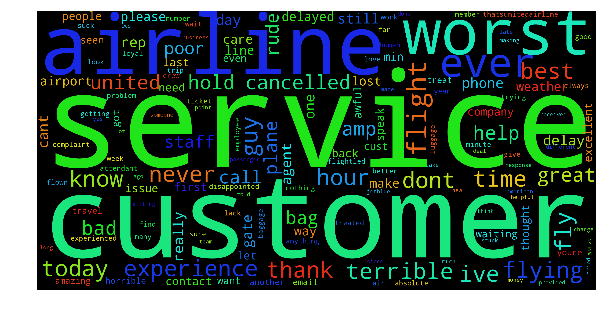

In [153]:
makeWordCloud(sortedTpx2)

In [154]:
sortedTpx2

[['moodlighting',
  'way',
  'fly',
  'best',
  'experience',
  'ever',
  'cool',
  'calming',
  '#moodlitmonday'],
 ['done', 'done', 'best', 'airline', 'around', u'hand'],
 ['julie', u'andrew', u'hand'],
 ['congrats', 'winning', 'award', 'best', u'deal', 'airline'],
 ['emailed',
  'customer',
  'service',
  'team',
  'let',
  'know',
  'need',
  'tracking',
  'number'],
 ['going', 'customer', 'service', 'anyway', 'speak', 'human', 'asap', 'thank'],
 ['cant',
  'supp',
  'biz',
  'traveler',
  'like',
  'customer',
  'service',
  'like',
  '#neverflyvirginforbusiness'],
 ['youre',
  'best',
  'whenever',
  'begrudgingly',
  'airline',
  'delayed',
  'late',
  'flight'],
 ['-',
  'amazing',
  'customer',
  'service',
  'raeann',
  'sf',
  '-',
  'shes',
  'best',
  '#customerservice',
  '#virginamerica',
  '#flying'],
 ['called', 'service', 'line', 'hung', 'awesome', '#sarcasm'],
 ['best',
  'airline',
  'flown',
  'oneasy',
  'change',
  'reservationhelpful',
  u'representative',
  'am

In [49]:
#list(np.unique(kagTweets.airline))`

['American', 'Delta', 'Southwest', 'US Airways', 'United', 'Virgin America']

In [51]:
#airlinePop

In [155]:
airlinePop = np.array(kagTweets.loc[sortedIdx]['airline'])
len(airlinePop)
#Counter(resample(airlinePop))
airlineNames = list(np.unique(kagTweets.airline))
testDf=pd.DataFrame(columns=airlineNames)
for i in range(1000):
    tempSample = pd.Series(dict(Counter(resample(airlinePop))))
    testDf = testDf.append(tempSample,ignore_index=True)
#testDf.head()

In [156]:
# Then normalize all data points to the original representation in the tweet dataset
totalAirTweets = dict(Counter(kagTweets['airline']))
for i in totalAirTweets.keys():
    normVal = testDf[i]/float(totalAirTweets[i])
    testDf[i + '-norm'] = pd.Series(normVal,index=testDf.index)


In [54]:
#testDf.head()

In [55]:
#United vs American

In [157]:
# Then get the 95% CI for each airline
# Now I need to calc for each airline
testSort = np.sort(testDf['American-norm'])
low95 = testSort[24]
hi95 = testSort[975]
meanVal = np.mean(testSort)
print meanVal, low95, hi95


0.0636919173614 0.0550924247916 0.0728524827836


In [158]:
statDf = pd.DataFrame(columns=['mean','low95','hi95'])
for airline in airlineNames:
    tempName = airline + '-norm'
    tempSort = np.sort(testDf[tempName])
    meanVal = np.mean(tempSort)
    low95 = meanVal - tempSort[24] 
    hi95 = tempSort[975] - meanVal
    statDf = statDf.append({'mean': meanVal,'low95':low95,'hi95':hi95},ignore_index=True)

statDf.index = airlineNames
statDf = statDf.sort_values('mean')
statDf = statDf/statDf.iloc[0]['mean']

In [159]:
#statDf.iloc[0]['mean']

1.0

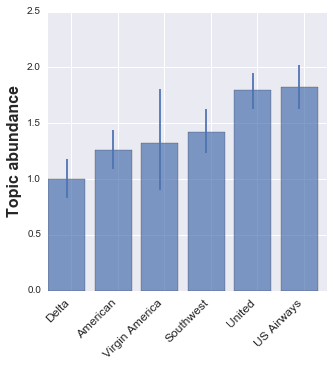

In [160]:
fig = plt.figure(figsize=(5,5), dpi=1600)
ax = plt.subplot(111)

barPlot = plt.bar(range(6),statDf.loc[:,'mean'],yerr=[list(statDf.loc[:,'low95']),list(statDf.loc[:,'hi95'])],alpha=0.7)
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in barPlot]
plt.xticks([i+0.5 for i in range(6)],list(statDf.index),rotation=45,ha='right',fontsize=12)
ax.set_ylabel('Topic abundance',fontsize=16,fontweight='bold')
plt.show()

In [183]:
jdAirline = {'Delta': 706, 'American': 700,'United': 665,'US Airways': 668,}
#plt.bar(range(len(jdAirline)),jdAirline.values())
#len(jdAirline)
jdAirline.values()

[700, 665, 668, 706]

In [247]:
jdDf = pd.DataFrame(columns=['airline','value'])
for airline in jdAirline.keys():
    jdDf = jdDf.append(pd.Series({'airline':airline,'value': jdAirline[airline]}),ignore_index=True)
    #print pd.Series({'airline': jdAirline[airline],'value':airline})
    #print jdAirline[airline]

jdDf = jdDf.iloc[[3,0,1,2]]   
#jdDf.loc[:,'relativeValue'] = jdDf['value']/min(jdDf['value'])
#jdDf.loc[:,'relativeValue'] = jdDf['value']-min(jdDf['value'])
#jdDf.loc[:,'norm'] = jdDf.relativeValue/max(jdDf.relativeValue)
#jdDf.loc[:,'relativeValue'] = (jdDf['value']-691)/691*100
jdDf.loc[:,'relativeValue'] = (jdDf['value']-691)
jdDf


,airline,value,relativeValue
3,Delta,706,15
0,American,700,9
1,United,665,-26
2,US Airways,668,-23


(-30, 20)

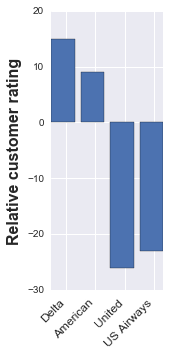

In [250]:
fig = plt.figure(figsize=(2,5), dpi=1600)
ax = plt.subplot(111)

#sns.barplot(x='airline',y='value',data=jdDf)

xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in barPlot]
plt.xticks([i+0.5 for i in range(6)],list(jdDf.airline),rotation=45,ha='right',fontsize=12)
ax.set_ylabel('Relative customer rating',fontsize=16,fontweight='bold')

ax = plt.bar(range(len(jdDf)),jdDf['relativeValue'])
plt.ylim([-30,20])
#plt.ylim([500,750])

NameError: name 'dfStats' is not defined

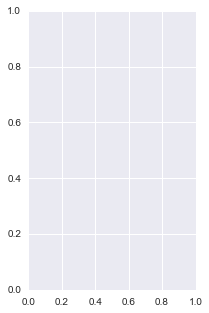

In [161]:
### barplot 
fig = plt.figure(figsize=(3,5), dpi=1600)
ax = plt.subplot(111)

barPlot = plt.bar(range(6),dfStats.loc[:,'mean'],yerr=[list(dfStats.loc[:,'low95']),list(dfStats.loc[:,'high95'])],alpha=0.5)

xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in barPlot]
plt.xticks([i+0.5 for i in range(6)],dfStats.loc[:,'algorithm'],rotation=45,ha='right')
ax.set_ylabel('Prediction accuracy',fontsize=16,fontweight='bold')
plt.show()

In [ ]:
#kagTweets

In [ ]:
testSort = np.sort(testDf['United-norm'])
low95 = testSort[24]
hi95 = testSort[975]
meanVal = np.mean(testSort)
print meanVal, low95, hi95

In [ ]:
len(set(resample(range(0,1000))))

In [ ]:
junk = np.array(range(1000))
len(junk[junk>24])
len(junk[junk<975])

In [ ]:
Counter(kagTweets.loc[sortByTopicTweet(kagCleanArray,kagDf,'topic27')]['airline'])

### Need to normailze to the proportional airline counts
### Have to sort list by list

In [ ]:
[airCounts[i]/float(testList[i]) for i in range(len(testList))]

In [ ]:
def plotTopicAirDist(origTweets,myTopic,mySortedDf):
    myCleanArray = np.array(cleanedTweetList)
    srtIdx = list(mySortedDf[mySortedDf[myTopic]>myTopicThresh].index)
    airCounts = Counter(origTweets.loc[sortByTopicTweet(kagCleanArray,kagDf,'topic27')]['airline'])

In [ ]:
airCounts = Counter(kagTweets.loc[sortByTopicTweet(kagCleanArray,kagDf,'topic27')]['airline'])
sortedAirCounts = sorted(airCounts.items(), key=lambda x: x[1],reverse=True)[0:5]

airNames = [airline[0] for airline in sortedAirCounts]
airCounts = [airline[1] for airline in sortedAirCounts]

indexes = np.arange(len(airNames))
width = 0.9
plt.bar(indexes, airCounts, width)
plt.xticks(indexes + width * 0.5, airNames)
plt.ylabel('Frequency',fontsize=16)

# Plot histogram using matplotlib bar().
#indexes = np.arange(len(author_names))
#width = 0.7
#plt.bar(indexes, author_counts, width)
#plt.xticks(indexes + width * 0.5, author_names)
plt.show()
#

In [ ]:
airCounts = Counter(kagTweets.loc[sortByTopicTweet(kagCleanArray,kagDf,'topic27')]['airline'])
sortedAirCounts = sorted(airCounts.items(), key=lambda x: x[1],reverse=True)[0:5]

airNames = [airline[0] for airline in sortedAirCounts]
airCounts = [airline[1] for airline in sortedAirCounts]

indexes = np.arange(len(airNames))
width = 0.9
plt.bar(indexes, airCounts, width)
plt.xticks(indexes + width * 0.5, airNames)
plt.ylabel('Frequency',fontsize=16)

# Plot histogram using matplotlib bar().
#indexes = np.arange(len(author_names))
#width = 0.7
#plt.bar(indexes, author_counts, width)
#plt.xticks(indexes + width * 0.5, author_names)
plt.show()
#

In [ ]:
totalAirCounts = Counter(kagTweets['airline'])
#totalAirCounts[['American','United'])]
sortedTotalAirCounts = sorted(totalAirCounts.items(), key=lambda x: x[1],reverse=True)[0:5]
testDict = dict(sortedTotalAirCounts)
testList = [testDict[airline] for airline in airNames]
normAirCounts = [airCounts[i]/float(testList[i])*100 for i in range(len(testList))]

airNames = [airline[0] for airline in sortedAirCounts]
#airCounts = [airline[1] for airline in sortedAirCounts]

indexes = np.arange(len(airNames))
width = 0.9
plt.bar(indexes, normAirCounts, width)
plt.xticks(indexes + width * 0.5, airNames)
plt.ylabel('Frequency',fontsize=16)



#[airline[0] for airline in sortedTotalAirCounts]
#[airline[1] for airline in sortedTotalAirCounts]

#airNames = [airline[0] for airline in sortedAirCounts]
#print sortedTotalAirCounts
#print sortedTotalAirCounts.keys()
#print sortedTotalAirCounts.values()

## Bootstrap resampling to get errors on the airline proportions

In [ ]:
### Working
def sortByTopic(cleanedTweetList,mySortedDf,myTopic,myTopicThresh=0.1):
    myCleanArray = np.array(cleanedTweetList)
    srtIdx = list(mySortedDf[mySortedDf[myTopic]>myTopicThresh].index)
    srtTweets = list(myCleanArray[srtIdx])
    return srtTweets

In [ ]:
airCounts = Counter(kagTweets.loc[sortByTopicTweet(kagCleanArray,kagDf,'topic27')]['airline'])
sortedAirCounts = sorted(airCounts.items(), key=lambda x: x[1],reverse=True)[0:5]

airNames = [airline[0] for airline in sortedAirCounts]
airCounts = [airline[1] for airline in sortedAirCounts]

indexes = np.arange(len(airNames))
width = 0.9
plt.bar(indexes, airCounts, width)
plt.xticks(indexes + width * 0.5, airNames)
plt.ylabel('Frequency',fontsize=16)

# Plot histogram using matplotlib bar().
#indexes = np.arange(len(author_names))
#width = 0.7
#plt.bar(indexes, author_counts, width)
#plt.xticks(indexes + width * 0.5, author_names)
plt.show()
#

In [ ]:
topHandlerCounts = Counter(topHandlers)
sortedHandlers = sorted(topHandlerCounts.items(), key=lambda x: x[1],reverse=True)[0:5]

handlerNames = [handler[0] for handler in sortedHandlers]
handlerCounts = [handler[1] for handler in sortedHandlers]

indexes = np.arange(len(handlerNames))
width = 0.9
plt.bar(indexes, handlerCounts, width)
plt.xticks(indexes + width * 0.5, handlerNames)
plt.ylabel('Frequency',fontsize=16)

# Plot histogram using matplotlib bar().
#indexes = np.arange(len(author_names))
#width = 0.7
#plt.bar(indexes, author_counts, width)
#plt.xticks(indexes + width * 0.5, author_names)
plt.show()
#

In [ ]:
topic24words = sortByTopic(cleanKagTweetList,kagDf,myTopic='topic24')

In [ ]:
#topic3words

In [ ]:
#def makeWordCloud(mySortedTweets):
#    filteredWords = ' '.join([' '.join(string) for string in mySortedTweets])
#    topicCloud = WordCloud(max_font_size=100,scale=8).generate(topicCloudWords)
#    return WordCloud(max_font_size=100,scale=8).generate(topicCloudWords)
    

In [ ]:
def makeWordCloud(mySortedTweets):
    filteredWords = ' '.join([' '.join(string) for string in mySortedTweets])
    #topicCloud = WordCloud(max_font_size=100,scale=8).generate(topicCloudWords)
    myTopicCloud = WordCloud(max_font_size=100,scale=8).generate(filteredWords)
    fig = plt.figure(figsize=(10,10), dpi=1600)
    plt.imshow(myTopicCloud)
    plt.axis("off")
    plt.show()

In [ ]:
makeWordCloud(topic24words)

In [ ]:
fig = plt.figure(figsize=(10,10), dpi=1600)
myTopicCloud=makeWordCloud(topic1words)
plt.imshow(myTopicCloud)
plt.axis("off")
plt.show()

In [ ]:
makeWordCloud(topic1words)
#makeWordCloud(cleanKagTweetList)

In [ ]:
#len(cleanKagTweetList)

In [ ]:
#sortByTopic(cleanKagTweetList,kagSortedDf2)

In [16]:
kagSortedDf2 = createDenseMat(kagLda,kagCorpus,translateIdx)

NameError: name 'createDenseMat' is not defined

In [17]:
kagCleanArray = np.array(cleanKagTweetList)
#kagCleanArray
srtIdx = list(kagSortedDf[kagSortedDf.col1>0.1].index)
srtTweets = list(kagCleanArray[srtIdx])
topicCloudWords = ' '.join([' '.join(string) for string in srtTweets])

NameError: name 'cleanKagTweetList' is not defined

In [ ]:
kagDense = corpus2dense(kagLda[kagCorpus],50)
kagDf = pd.DataFrame(kagDense)
kagSortedDf = kagDf.transpose()
kagSortedDf = kagDf.transpose()[translateIdx]
kagSortedDf.columns = ['col' + str(i + 1) for i in range(50)]
kagSortedDf.sort_values('col1',ascending=False).head()

In [154]:
#translateLdaIdx(kagLda)

In [151]:
#translateIdx

# is this right?

In [594]:
#idxDf = pd.DataFrame(columns=['first','second','third'])
#kagShowTopics

In [592]:
idxShufDf = pd.DataFrame(columns=['first','second','third'])
kagShowTopics = kagLda.show_topics(50)
for i in range(len(kagLda.show_topics(50))):
    idxShufDf.loc[i,'first']=kagShowTopics[i][1].split()[0].split('*')[1]
    idxShufDf.loc[i,'second']=kagShowTopics[i][1].split()[2].split('*')[1]
    idxShufDf.loc[i,'third']=kagShowTopics[i][1].split()[4].split('*')[1]
idxShufDf.head()

,first,second,third
0,person,service,experience
1,link,thx,agent
2,ever,member,ive
3,hour,flight,change
4,book,travel,guy


In [595]:
kagTopTopics = kagLda.top_topics(kagCorpus)
idxTopDf = pd.DataFrame(columns=['first','second','third'])
for i in range(len(kagTopTopics)):
    idxTopDf.loc[i,'first']=kagTopTopics[i][0][0][1] 
    idxTopDf.loc[i,'second']=kagTopTopics[i][0][1][1] 
    idxTopDf.loc[i,'third']=kagTopTopics[i][0][2][1] 

idxTopDf.head()

,first,second,third
0,hold,flight,help
1,flight,cancelled,flightled
2,flight,get,home
3,delayed,flight,time
4,flight,still,waiting


In [597]:
#idxTopDf

In [606]:
translateIdx

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49]

In [608]:
kagTopTopics[0]

([(0.069081547140009067, u'hold'),
  (0.051946239556114951, u'flight'),
  (0.048468121452699547, u'help'),
  (0.043372461265078183, u'call'),
  (0.037195251998753481, u'need'),
  (0.036742654078024288, u'hour'),
  (0.033349534254853958, u'tomorrow'),
  (0.032186123316162663, u'get'),
  (0.030014570866952694, u'reservation'),
  (0.028469339361524008, u'trying'),
  (0.022575462006282795, u'please'),
  (0.021934533768779692, u'back'),
  (0.020073880851627379, u'cancelled'),
  (0.019263096744484589, u'ive'),
  (0.01796390274984801, u'cant'),
  (0.014318990375090369, u'morning'),
  (0.011926655664130495, u'rebook'),
  (0.01130792254242848, u'minute'),
  (0.011062481154020873, u'change'),
  (0.010538490128589062, u'online')],
 -985.23886739574914)

In [612]:
kagLda.show_topics(50)[25]

(25,
 u'0.069*hold + 0.052*flight + 0.048*help + 0.043*call + 0.037*need + 0.037*hour + 0.033*tomorrow + 0.032*get + 0.030*reservation + 0.028*trying')

In [599]:
# This one is good for translate index
translateIdx = []

for j in range(50):
    for i in range(50):
        if list(idxShufDf['first'])[i] == idxTopDf.loc[j,'first']:
            if list(idxShufDf['second'])[i] == idxTopDf.loc[j,'second']:
                if list(idxShufDf['third'])[i] == idxTopDf.loc[j,'third']:              
                    translateIdx.append(i)
                    #print i, j

In [607]:
#switch i,j try
translateIdx = []

for j in range(50):
    for i in range(50):
        if list(idxShufDf['first'])[j] == idxTopDf.loc[i,'first']:
            if list(idxShufDf['second'])[j] == idxTopDf.loc[i,'second']:
                if list(idxShufDf['third'])[j] == idxTopDf.loc[i,'third']:              
                    translateIdx.append(i)
                    #print i, j

In [602]:
#kagSparse = corpus2csc(kagCorpus)
#kagDense = corpus2dense(kagCorpus,14640)
kagDense = corpus2dense(kagLda[kagCorpus],50)
kagDf = pd.DataFrame(kagDense)
kagDf.shape
kagSortedDf = kagDf.transpose()
kagSortedDf = kagDf.transpose()[translateIdx]
kagSortedDf.columns = ['col' + str(i + 1) for i in range(50)]
kagSortedDf.sort_values('col1',ascending=False).head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col41,col42,col43,col44,col45,col46,col47,col48,col49,col50
12950,0.996744,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13252,0.996245,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12383,0.995934,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12389,0.995934,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11745,0.995934,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [591]:
#works
#idxShufDf.loc[39,['first','second','third']] == idxTopDf.loc[0,['first','second','third']]
print idxShufDf.loc[39,'first'] == idxTopDf.loc[0,'first']
print idxShufDf.loc[39,'second'] == idxTopDf.loc[0,'second']
print idxShufDf.loc[39,'third'] == idxTopDf.loc[0,'third']

idxShufDf.loc[39,'first'] == idxTopDf.loc[0,'first'] and idxShufDf.loc[39,'second'] == idxTopDf.loc[0,'second'] and idxShufDf.loc[39,'third'] == idxTopDf.loc[0,'third']
#    print 'yes'
#idxShufDf.loc[39,'first'] == idxTopDf.loc[0,'first'] and print idxShufDf.loc[39,'second'] == idxTopDf.loc[0,'second'] and print idxShufDf.loc[39,'third'] == idxTopDf.loc[0,'third']


False
True
False


False

# Now just do this in a loop to get the index matching

In [137]:
#print translateIdx


### Next sort tweets according to the topic abundance

In [131]:
# I think I may need to add 1 to all the indices

#kagSortedDf = kagDf.transpose()
#kagSortedDf = kagDf.transpose()[translateIdx]
#kagSortedDf.columns = [i + 1 for i in translateIdx]
#kagSortedDf.sort_values(39,ascending=False).head()

In [133]:
#kagTweets.loc[14216]['text']

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col41,col42,col43,col44,col45,col46,col47,col48,col49,col50
14166,0.996947,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13760,0.996744,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12053,0.996245,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2079,0.996245,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11892,0.996245,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
#kagDf.loc[12593]
kagTweets.loc[14166,'text']

'@AmericanAir fight got Cancelled Flighted can u help me rebook a flight?  Call center is too busy to answer calls or even put me on hold #yuck'

In [ ]:
kag

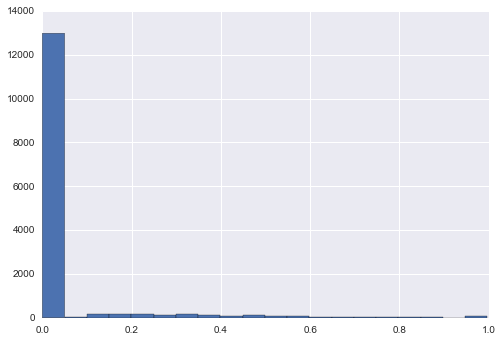

In [552]:
ax =kagSortedDf2['col1'].hist(bins=20)
plt.show()

In [127]:
#cleanKagTweetList
list(kagSortedDf[kagSortedDf.col1>0.1].index)
#kagTweets.loc[list(set(kagSortedDf[kagSortedDf.col1>0.1].index))]['text']

[55,
 66,
 67,
 70,
 86,
 89,
 98,
 101,
 107,
 114,
 126,
 137,
 156,
 158,
 159,
 196,
 200,
 201,
 205,
 226,
 232,
 235,
 277,
 282,
 318,
 326,
 334,
 335,
 340,
 344,
 360,
 365,
 372,
 386,
 445,
 450,
 456,
 463,
 479,
 487,
 499,
 509,
 564,
 569,
 573,
 593,
 606,
 610,
 643,
 650,
 652,
 655,
 675,
 700,
 704,
 711,
 715,
 716,
 719,
 764,
 786,
 792,
 796,
 803,
 808,
 833,
 843,
 844,
 847,
 862,
 884,
 899,
 918,
 923,
 928,
 934,
 939,
 960,
 961,
 986,
 990,
 996,
 1008,
 1041,
 1064,
 1070,
 1073,
 1097,
 1098,
 1102,
 1119,
 1121,
 1130,
 1133,
 1135,
 1149,
 1158,
 1166,
 1215,
 1229,
 1263,
 1265,
 1266,
 1269,
 1272,
 1287,
 1294,
 1297,
 1326,
 1331,
 1333,
 1346,
 1350,
 1361,
 1373,
 1419,
 1422,
 1436,
 1468,
 1510,
 1520,
 1527,
 1533,
 1561,
 1570,
 1590,
 1600,
 1621,
 1656,
 1660,
 1673,
 1688,
 1718,
 1719,
 1732,
 1747,
 1760,
 1761,
 1766,
 1767,
 1773,
 1781,
 1796,
 1800,
 1813,
 1816,
 1824,
 1839,
 1847,
 1874,
 1875,
 1879,
 1896,
 1901,
 1904,
 191

In [ ]:
list(kagSortedDf[kagSortedDf.col1>0.1].index)

In [128]:
#kagSortedDf[(kagSortedDf.col1>0.4) & (kagSortedDf.col1<0.5)]

In [129]:
kagTweets.loc[89]['text']

'@VirginAmerica Why is the site down?  When will it be back up?'

In [84]:
kagCleanArray = np.array(cleanKagTweetList)
#kagCleanArray
srtIdx = list(kagSortedDf[kagSortedDf.col1>0.1].index)
srtTweets = list(kagCleanArray[srtIdx])
topicCloudWords = ' '.join([' '.join(string) for string in srtTweets])

In [107]:
#srtTweets

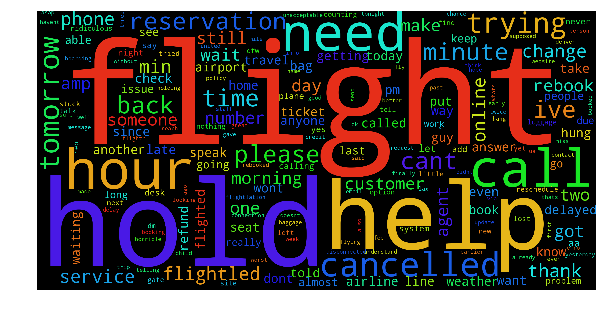

In [206]:
#topicCloud = WordCloud(max_font_size=100,scale=8).generate(topicCloudWords)
#topicCloud = WordCloud(max_font_size=100,scale=8).generate(' '.join([' '.join(string) for string in srtTweets]))

myTopicCloud = makeWordCloud(cleanKagTweetList)

fig = plt.figure(figsize=(10,10), dpi=1600)
plt.imshow(myTopicCloud)
plt.axis("off")
plt.show()

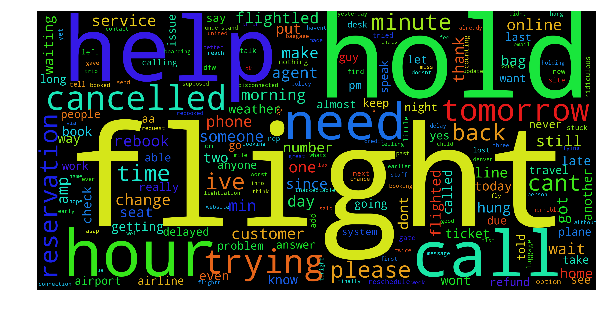

In [203]:
topicCloud = WordCloud(max_font_size=100,scale=8).generate(topicCloudWords)
#topicCloud = WordCloud(max_font_size=100,scale=8).generate(' '.join([' '.join(string) for string in srtTweets]))

fig = plt.figure(figsize=(10,10), dpi=1600)
plt.imshow(topicCloud)
plt.axis("off")
plt.show()

### Parameters I want to get an intuition for
1. What are perplexity metrics?
2. How many documents do I need for this to be effective?
3. How does using a different alpha value change the topics obtained by the model?
4. Does topic number reduce perplexity? Will more topics always reduce perplexity?


In [93]:
#models.ldamulticore.LdaMulticore.log_perplexity(kagLda)
kagLda.log_perplexity(kagCorpus)

-9.3352311417525442

In [110]:
tempLDA = createLDA(kagCorpus, kagDict,myTopics=20)

In [111]:
pyLDAvis.gensim.prepare(tempLDA, kagCorpus, kagDict)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      12.342593        1       1 -0.167412 -0.023112
16      7.595106        1       2 -0.102757 -0.081826
9       6.556064        1       3 -0.053864  0.026497
0       5.960392        1       4 -0.076083 -0.113312
8       5.541048        1       5 -0.049382  0.062970
14      5.492479        1       6 -0.024098  0.070083
1       5.228620        1       7  0.136721 -0.142235
4       5.126752        1       8  0.059396 -0.070064
2       4.507879        1       9 -0.031332 -0.003253
6       4.335051        1      10  0.193753 -0.106785
17      4.271573        1      11 -0.058222 -0.060857
11      4.223480        1      12  0.002392  0.030150
3       4.061831        1      13  0.052400  0.025468
5       3.983982        1      14  0.004033  0.021925
18      3.929081        1      15 -0.068613 -0.028847
19      3.906088        1      16 -0.083709  0.042434
10      3.783042        1      17  0.055068 -0.005059
15      3.509125        1      18  0.032857  0.130090
12      3.312629        1      19  0.113096  0.152488
13      2.333186        1      20  0.065756  0.073245, topic_info=      Category         Freq             Term  Total  loglift  logprob
7674   Default  1048.000000        cancelled   1048  30.0000  30.0000
322    Default   976.000000          service    976  29.0000  29.0000
6725   Default   755.000000              bag    755  28.0000  28.0000
2550   Default   917.000000         customer    917  27.0000  27.0000
7318   Default   601.000000            thank    601  26.0000  26.0000
11646  Default  4494.000000           flight   4494  25.0000  25.0000
1277   Default   502.000000        flightled    502  24.0000  24.0000
3775   Default  1066.000000           thanks   1066  23.0000  23.0000
6426   Default   548.000000             call    548  22.0000  22.0000
8375   Default   555.000000           please    555  21.0000  21.0000
1761   Default   714.000000            plane    714  20.0000  20.0000
10450  Default   216.000000          jetblue    216  19.0000  19.0000
11148  Default   232.000000            worst    232  18.0000  18.0000
139    Default   637.000000             hold    637  17.0000  17.0000
7822   Default   538.000000          airline    538  16.0000  16.0000
6375   Default   243.000000             ever    243  15.0000  15.0000
8870   Default   253.000000               dm    253  14.0000  14.0000
7539   Default  1371.000000              get   1371  13.0000  13.0000
5290   Default   152.000000            fleet    152  12.0000  12.0000
5281   Default   148.000000            fleek    148  11.0000  11.0000
2881   Default   246.000000            email    246  10.0000  10.0000
6385   Default   317.000000            never    317   9.0000   9.0000
8139   Default   423.000000             late    423   8.0000   8.0000
9654   Default   539.000000             gate    539   7.0000   7.0000
4264   Default   305.000000         tomorrow    305   6.0000   6.0000
3163   Default   308.000000          problem    308   5.0000   5.0000
11119  Default   127.000000           follow    127   4.0000   4.0000
4278   Default   223.000000         flighted    223   3.0000   3.0000
4676   Default   519.000000          delayed    519   2.0000   2.0000
6994   Default   306.000000           flying    306   1.0000   1.0000
...        ...          ...              ...    ...      ...      ...
7258   Topic20    36.588606            agent    413   1.4043  -4.3263
7372   Topic20     4.984469           living      9   3.3482  -6.2086
8323   Topic20    14.631926             fine     39   2.5949  -5.4956
8593   Topic20    22.594550           newark     57   2.3905  -5.3205
6457   Topic20     1.997503  #thenewamerican      4   3.7437  -6.6241
8209   Topic20     9.258771         pleasant     14   3.0659  -6.0492
5179   Topic20    22.141076          flightr    155   1.7151  -4.9956
6540   Topic20     3.257620     indiana

### Could be nice to see which airline has the most trouble or gets the most positive responses

In [99]:
#get unique airlines in dataset
np.unique(kagTweets['airline'])

array(['American', 'Delta', 'Southwest', 'US Airways', 'United',
       'Virgin America'], dtype=object)

In [101]:
tempLDA = createLDA(kagCorpus, kagDict,myPasses=1,myIterations=1)

In [103]:
tempLDA.log_perplexity(kagCorpus)

-35.165851361464973

In [105]:
myNumTopics = [5,10,15,20,30,40,50,60,70,80,90,100,125,150,175,200]

In [106]:
for i in myNumTopics:
    tempLDA = createLDA(kagCorpus, kagDict,myPasses=10,myIterations=50,myTopics=i)
    print tempLDA.log_perplexity(kagCorpus)

-8.59480084875
-8.78183116319
-8.88128765747
-8.98503369168
-9.1106256775
-9.25185504989
-9.33457901644
-9.4047096351
-9.45487341335
-9.52136222915
-9.58958047556
-9.5906977889
-9.72553756621
-9.80253888669
-9.84237057044
-9.83243885693


In [ ]:
kagLda = createLDA(kagCorpus, kagDict)

In [104]:
kagLda.num_topics

50

In [ ]:
>>> import numpy as np
>>> a = np.array([-2, 1, 5, 3, 8, 5, 6])
>>> b = [1, 2, 5]
>>> print list(a[b])
[1, 5, 5]

In [ ]:
#kagDf.iloc[translateIdx].reset_index()

In [ ]:
#np.sort(kagDf.loc[39,])
kagDf.sort_values()

# Try to implement bigrams into analysis

In [ ]:
from gensim.models.phrases import Phrases
from gensim import similarities


In [ ]:
def getBigram(myTweetlist):
    bigram = Phrases(tweetList)
    return [bigram[tweet] for tweet in myTweetlist]

In [ ]:
cleanTweets = filterTweetList(tweets['message'])
bigramTweetList = getBigram(cleanTweets)

In [ ]:
bigramDict = makeDict(bigramTweetList)
bigramCorpus = makeCorpus(bigramTweetList)

#bigramDict = bigramDict.compactify()
bigramLda = createLDA(myCorpus = bigramCorpus, myDictionary = bigramDict)
#dictionary.

#createLDA()

In [ ]:
bigramDict = makeDict(bigramTweetList)
bigramLda = createLDA(myCorpus = bigramCorpus, myDictionary = bigramDict)

In [ ]:
#bigramDict = bigramDict.compactify()

In [ ]:
pyLDAvis.gensim.prepare(bigramLda, bigramCorpus, bigramDict)

# Code for single tweet validation 

In [ ]:
# First, build index in order to query the model

myIndex = MatrixSimilarity(lda[myCorpus]) # transform corpus to LSI space and index it
sims = myIndex[myVec_lda] # perform a similarity query against the corpus
sims = sorted(enumerate(sims), key=lambda item: -item[1])



In [ ]:
# Function for tweet validation

def validateTweet(testTweet, myDict=myDict, myLda=lda ):
    myDoc = ' '.join([prepText(word) for word in testTweet.split() if prepText(word) is not None])    
    myVec_bow = myDict.doc2bow(myDoc.lower().split())
    myVec_lda = myLda[myVec_bow]
    sims = myIndex[myVec_lda] # perform a similarity query against the corpus
    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    matchIdx = [i[0] for i in sims[1:300]]
    topHandlers = list(tweets.iloc[matchIdx]['fromHandler'])
    return topHandlers

validateTweet("@JennyMcCarthy #dsf I wrote a children's book about bullying. It's on Amazon. Want to help promote it?!? The Bully's Nightmare")

In [ ]:
#Trial tweet for validation

myDoc = '@saracozart No need to continue the struggle. Were here and we can help. DM us for info about switching. http://spr.ly/6017BkrjL* OMV'
myDocOrig = "@ATT @ATTCares I have been on hold for one hour & 11minutes. This is a little excessive. Worst customer service I've ever received."
myDoc = ' '.join([prepText(word) for word in myDoc.split() if prepText(word) is not None])
print myDoc                
myVec_bow = myDict.doc2bow(myDoc.lower().split())
#myVec_bow = dictionary.doc2bow(myDoc.lower().split())
myVec_lda = lda[myVec_bow]
print(myVec_lda)

In [ ]:
# Find the best 300 tweet matches
matchIdx = [i[0] for i in sims[1:300]]
topHandlers = list(tweets.iloc[matchIdx]['fromHandler'])

In [ ]:
#>>> sims = myIndex[myVec_lda] # perform a similarity query against the corpus
#>>> print(list(enumerate(sims))) # print (document_number, document_similarity) 2-tuples

In [ ]:
#>>> sims = sorted(enumerate(sims), key=lambda item: -item[1])
#>>> print(sims) # print sorted (document number, similarity score) 2-tuples

In [ ]:
# Find the best 300 tweet matches
#matchIdx = [i[0] for i in sims[1:300]]


In [ ]:
topHandlerCounts = Counter(topHandlers)
sortedHandlers = sorted(topHandlerCounts.items(), key=lambda x: x[1],reverse=True)[0:5]

handlerNames = [handler[0] for handler in sortedHandlers]
handlerCounts = [handler[1] for handler in sortedHandlers]

indexes = np.arange(len(handlerNames))
width = 0.9
plt.bar(indexes, handlerCounts, width)
plt.xticks(indexes + width * 0.5, handlerNames)
plt.ylabel('Frequency',fontsize=16)

# Plot histogram using matplotlib bar().
#indexes = np.arange(len(author_names))
#width = 0.7
#plt.bar(indexes, author_counts, width)
#plt.xticks(indexes + width * 0.5, author_names)
plt.show()
#

In [ ]:
#Trial tweet for validation LSI

myDoc = '@saracozart No need to continue the struggle. Were here and we can help. DM us for info about switching. http://spr.ly/6017BkrjL* OMV'
myDocOrig = "@ATT @ATTCares I have been on hold for one hour & 11minutes. This is a little excessive. Worst customer service I've ever received."
myDoc = ' '.join([prepText(word) for word in myDoc.split() if prepText(word) is not None])
print myDoc                
myVec_bow = myDict.doc2bow(myDoc.lower().split())
#myVec_bow = dictionary.doc2bow(myDoc.lower().split())
myVec_lsi = lsi[myVec_bow]
print(myVec_lsi)

In [ ]:
# How would I get the topic distribution for the top tweets?

In [ ]:
simsLsi = myIndex[myVec_lsi] # perform a similarity query against the corpus
simsLsi = sorted(enumerate(simsLsi), key=lambda item: -item[1])
matchIdx = [i[0] for i in simsLsi[1:300]]
topHandlers = list(tweets.iloc[matchIdx]['fromHandler'])

In [ ]:
topHandlers

In [ ]:
#83287 words
# 50 topics
myIndex.index.shape

In [ ]:
# All 80k tweets for 4th topic
myIndex.index[:,4]

In [ ]:
# All 50 topics for 4th tweet
myIndex.index[4,:]

In [ ]:
#lda.print_topic(49)
lda.show_topic(49)

In [ ]:
tweets.iloc[matchIdx][1:300]

In [ ]:
sims[1:300]

In [ ]:
myDoc = '@saracozart No need to continue the struggle. Were here and we can help. DM us for info about switching. http://spr.ly/6017BkrjL* OMV'

>>> doc = "Human computer interaction"
>>> vec_bow = dictionary.doc2bow(doc.lower().split())
>>> vec_lsi = lsi[vec_bow] # convert the query to LSI space
>>> print(vec_lsi)

In [ ]:
>>> index = similarities.MatrixSimilarity(lsi[corpus]) # transform corpus to LSI space and index it

In [ ]:
>>> sims = index[vec_lsi] # perform a similarity query against the corpus
>>> print(list(enumerate(sims))) # print (document_number, document_similarity) 2-tuples

In [ ]:
>>> sims = sorted(enumerate(sims), key=lambda item: -item[1])
>>> print(sims) # print sorted (document number, similarity score) 2-tuples

In [ ]:
tweets.iloc[35536]['message']

In [ ]:
bigram = Phrases(tweetList)

In [ ]:
#from gensim.models import Phrases


#print bigram[tweetList[152:153]]

test     = bigram[tweetList[152:153]]
#testDict = Phrases(tweetList[152:153])

testDict =  corpora.Dictionary(test)
#print bigram[tweetList[152:153]]
print test.corpus
#phraseTest = Phrases(tweetList[152:153])


In [ ]:
for i in range(152,200):
    print bigram[tweetList[i]]

In [ ]:
#lda

In [ ]:
tfidf_lda= models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=8, passes = 10,
    iterations=50)

In [ ]:
topTopicsTfIdf = tfidf_lda.top_topics(corpus_tfidf)

In [ ]:
#topTopicsTfIdf
#pyLDAvis.gensim.prepare(tfidf_lda, corpus_tfidf, dictionary)

In [ ]:
frq = nltk.FreqDist(tweetList[3])

In [ ]:
polstops = [w[0] for w in frq.most_common(int(0.3*len(frq)))]
polstops

In [ ]:
frq.most_common(int(0.3*len(frq)))

In [ ]:
[w[0] for w in frq.most_common(int(0.1*len(frq)))]

In [ ]:
[word for word in tweetList[3] if word not in polstops]

In [ ]:
secTweetList = [[word for word in s if word not in polstops] for s in speeches]    

In [ ]:
for i in tweets['message']:
    if 'xi ' in i:
        print i

#'Just' in tweets['message'].iloc[0]

In [ ]:
iter

In [ ]:
tweets

# Try to get count vectorizer for bag of words

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [ ]:
vectorizer = CountVectorizer(min_df=1)


In [ ]:
X = vectorizer.fit_transform(verTweets['message'])

In [ ]:
#list(verTweets['message'])

# Trying gensim

In [ ]:
from gensim import corpora, models, similarities
from gensim.models import ldamodel

In [ ]:
list(verTweets['message'])

In [ ]:
>>> # remove common words and tokenize
documents = list(verTweets['message'])

>>> stoplist = set('for a of the and to in'.split())
>>> texts = [[word for word in document.lower().split() if word not in stoplist]
>>>          for document in documents]
>>>
>>> # remove words that appear only once
>>> from collections import defaultdict
>>> frequency = defaultdict(int)
>>> for text in texts:
>>>     for token in text:
>>>         frequency[token] += 1
>>>
>>> texts = [[token for token in text if frequency[token] > 1]
>>>          for text in texts]
>>>
>>> from pprint import pprint   # pretty-printer
#>>> pprint(texts)

In [ ]:
>>> dictionary = corpora.Dictionary(texts)
>>> dictionary.save('/tmp/deerwester.dict') # store the dictionary, for future reference
>>> print(dictionary)

In [ ]:
#lda = ldamodel.LdaModel(list(verTweets['message']), num_topics=10)

In [ ]:
ldamodel.

In [ ]:
print 'Representative duplicate tweet: \n'
print tweets.iloc[45185]['message']


In [ ]:
# Count the number of occurences of the above tweet

print tweets.iloc[45194]['message']
print
msg1 = 'I always confuse @JetBlue crew members when I use this bag\xe2\x80\xa6 \xe2\x80\x9cNo I don\xe2\x80\x99t work for JB\xe2\x80\xa6 ish\xe2\x80\xa6\xe2\x80\x9d\nWheels up to Boston! https://t.co/61fKRnYNpK'
dups1 = tweets[tweets.message == msg1]
print "number of dups: " + str(len(dups1)) + '\n'
dups1.head()


In [ ]:
def dupCounter(msg):
    """Count the number of repeated tweets that match a given string"""
    dups = tweets[tweets.message == msg]
    dups.head()
    return len(dups)

dupCounter(tweets.iloc[45194]['message'])    

In [ ]:
# Get all unique tweets

uniqTweets = list(set(tweets['message']))

print 'number of unique tweets: ' + str(len(uniqTweets))

# Only 136 unique tweets. Something looks wrong.

In [ ]:
# For each unique tweet, count the number of duplicate tweets 
dupCounts = []

for i in uniqTweets:
    dupCounts.append(dupCounter(i))


In [ ]:
#Plot the redundancy of tweets

plt.bar([i for i in range(len(dupCounts))],dupCounts)
plt.ylabel('Tweet redundancy',fontsize=16)
#plt.title('duplicate tweets',fontsize=24)
#plt.xlabel('unique tweets')
#plt.bar([i for i in range(10)],range(10))

plt.ylim([0,7000])

plt.show()

# Preliminary tweet cleaning

In [ ]:
# To build a list of tweets coming from and to JetBlue

toJetTweets   = list(set(tweets.loc[tweets.toHandler == '@JetBlue','message']))
fromJetTweets = list(set(tweets.loc[tweets.toHandler != '@JetBlue','message']))

In [ ]:
#[i.lower() for i in ' '.join(toJetTweets).split()]

In [ ]:
wordList = [i.lower() for i in ' '.join(uniqTweets).split()]
wordList = [i for i in wordList if i not in stopwords.words('english')]
#filtWords = [i for i in skillList.split() if i not in stopwords.words('english')]

In [ ]:
#wordList

In [ ]:
freqWord = Counter(wordList).most_common(10)

In [ ]:
def getFreqWords(tweetList,topWordThresh=10):
    wordList = [i.lower() for i in ' '.join(tweetList).split()]
    wordList = [i for i in wordList if i not in stopwords.words('english')]
    return Counter(wordList).most_common(topWordThresh)
getFreqWords(uniqTweets)

In [ ]:
uniqTweets
toJetTweets

In [ ]:
def plotFreqWords(freqWords):
    fig = plt.figure(figsize=(5,4), dpi=1600)
    ax = fig.add_subplot(111)

    plt.bar([i for i in range(10)],[i[1] for i in freqWords],alpha=0.7)
    plt.xticks([i+0.5  for i in range(10)], [i[0] for i in freqWords], rotation='vertical')

    ax.set_xticklabels([i[0] for i in freqWords],rotation=45,ha='right')
    ax.set_ylim(0,25)
    ax.set_ylabel('Word Frequency',fontsize=16)

    plt.show()
    
plotFreqWords(getFreqWords(fromJetTweets))

In [ ]:
fig = plt.figure(figsize=(5,4), dpi=1600)
ax = fig.add_subplot(111)


plt.bar([i for i in range(10)],[i[1] for i in freqWord],alpha=0.7)
plt.xticks([i+0.5  for i in range(10)], [i[0] for i in freqWord], rotation='vertical')

ax.set_xticklabels([i[0] for i in freqWord],rotation=45,ha='right')
ax.set_ylim(0,25)
ax.set_ylabel('Word Frequency',fontsize=16)

plt.show()

In [ ]:
for i in uniqTweets:
    if 'thanks' in i:
        print i
    

In [ ]:
x = [1, 2, 3, 4]
y = [1, 4, 9, 6]
labels = ['Frogs', 'Hogs', 'Bogs', 'Slogs']

plt.plot(x, y, 'ro')
# You can specify a rotation for the tick labels in degrees or with keywords.
plt.xticks(x, labels, rotation='vertical')
# Pad margins so that markers don't get clipped by the axes
plt.margins(0.2)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
plt.show()

In [ ]:
[len(freqWord)]

In [ ]:
sorted(wordList.items(), key=operator.itemgetter(1),reverse=True)

In [ ]:
sortedFreq = sorted(wordList.items(), key=operator.itemgetter(1),reverse=True)

In [ ]:
dict(sortedFreq)

In [ ]:
#plt.plot([i for i in range(len(sortedFreq))],sortedFreq)

In [ ]:
print tweets.iloc[45185]['message']

In [ ]:
print tweets.iloc[45229]['message']
tweets.iloc[45229]['message']

In [ ]:
tknzr = TweetTokenizer()

In [ ]:
tknzr.tokenize(tweets.iloc[45229]['message'])

In [ ]:
len(list(set(tweets.message)))

In [ ]:
[i for i in wordList if i.startswith('#')]
[i for i in wordList if i.startswith('@')]

In [ ]:
print uniqTweets[0]
tknzr.tokenize(uniqTweets[0])

# Some sklearn stuff

In [ ]:
from sklearn.feature_extraction import DictVectorizer

In [ ]:
measurements = [
...     {'city': 'Dubai', 'temperature': 33.},
...     {'city': 'London', 'temperature': 12.},
...     {'city': 'San Fransisco', 'temperature': 18.},
... ]

In [ ]:
vec = DictVectorizer()

In [ ]:
vec.fit_transform(measurements).toarray()

In [ ]:
vec.get_feature_names()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = CountVectorizer(min_df=1)
vectorizer             

In [ ]:
>>> corpus = [
...     'This is the first document.',
...     'This is the second second document.',
...     'And the third one.',
...     'Is this the first document?',
... ]
>>> X = vectorizer.fit_transform(corpus)
>>> X             

In [ ]:
>>> analyze = vectorizer.build_analyzer()
>>> analyze("This is a text document to analyze.") == (
...     ['this', 'is', 'text', 'document', 'to', 'analyze'])


In [ ]:
>>> vectorizer.get_feature_names() == (
...     ['and', 'document', 'first', 'is', 'one',
...      'second', 'the', 'third', 'this'])
True

>>> X.toarray()           

In [ ]:
>>> vectorizer.vocabulary_.get('document')

In [ ]:
>>> vectorizer.transform(['Something completely new.']).toarray()

In [ ]:
>>> bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),
...                                     token_pattern=r'\b\w+\b', min_df=1)
>>> analyze = bigram_vectorizer.build_analyzer()
>>> analyze('Bi-grams are cool!') == (
...     ['bi', 'grams', 'are', 'cool', 'bi grams', 'grams are', 'are cool'])

In [ ]:
>>> X_2 = bigram_vectorizer.fit_transform(corpus).toarray()
>>> X_2

In [ ]:
>>> feature_index = bigram_vectorizer.vocabulary_.get('is this')
>>> X_2[:, feature_index]     

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np


In [ ]:
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# Uncomment the following to do the analysis on all the categories
#categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

In [ ]:
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

In [ ]:
print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

labels = dataset.target
true_k = np.unique(labels).shape[0]

In [ ]:
dataset.keys()
#dataset['DESCR']

In [ ]:
use_hashing = True
use_idf = True
n_features = 10000

print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
if use_hashing:
    if use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=n_features,
                                   stop_words='english', non_negative=True,
                                   norm=None, binary=False)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=n_features,
                                       stop_words='english',
                                       non_negative=False, norm='l2',
                                       binary=False)
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=use_idf)
X = vectorizer.fit_transform(dataset.data)


In [ ]:
n_components = 0
print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()


In [ ]:
###############################################################################
# Do the actual clustering

minibatchBool = True
verboseBool = False

if minibatchBool:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=verboseBool)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=opts.verbose)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()

In [ ]:
use_hashing = False

if not use_hashing:
    print("Top terms per cluster:")

    if n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

In [ ]:
dbname = 'tweets'
username = 'Peter'

In [ ]:
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print engine.url

In [ ]:
# Needed to use `createdb Peter` on bash terminal before psql would work
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

In [ ]:
tweets.to_sql('tweets_table', engine, if_exists='replace')

In [ ]:
# Create connection to database
con = psycopg2.connect(database = dbname, user = username)

In [ ]:
# query:
#sql_query = """
#SELECT * FROM tweets_table;
#"""

#select id, account, message from tweets_table limit 20;
#select * from tweets_table limit 20; 

sql_query = """
select id, account, message, tweet_id from tweets_table limit 5;
"""

def sqlPandasQuery(myQuery):
    tweets_from_sql = pd.read_sql_query(myQuery,con)
    return tweets_from_sql

sqlPandasQuery(sql_query)

In [ ]:
### can I do a SQL query to find conversations of given length?


In [ ]:
tweets.to_sql('tweets_table', engine, if_exists='replace')

In [ ]:
# Create connection to database
con = psycopg2.connect(database = dbname, user = username)

In [ ]:
# query:
#sql_query = """
#SELECT * FROM tweets_table;
#"""

#select id, account, message from tweets_table limit 20;
#select * from tweets_table limit 20; 

sql_query = """
select id, account, message, tweet_id from tweets_table limit 5;
"""

def sqlPandasQuery(myQuery):
    tweets_from_sql = pd.read_sql_query(myQuery,con)
    return tweets_from_sql

sqlPandasQuery(sql_query)

In [ ]:
### can I do a SQL query to find conversations of given length?

In [16]:
%%timeit
# Using iterator:             10 loops, best of 3: 137 ms per loop
# Using double list comprhxn: 10 loops, best of 3: 141 ms per loop

# Iterator
for tweet in (tweet for tweet in verTweets['message']):
    [word.lower() for word in tweet.split() if word not in str(stopwords.words('english')) and not word.startswith('@') and not word.startswith('http')]
#[[word.lower() for word in tweet.split() if word not in stopwords.words('english') and not word.startswith('@') and not word.startswith('http')] for tweet in verTweets['message']]


1 loops, best of 3: 7.9 s per loop


### Using an iterator doesn't speed up the data cleaning

## Wanted to check the speed saved by parallelization using `%%timeit`
#### Without multicore:  
_Code_  
`lda = models.LdaMulticore(corpus, id2word=dictionary, num_topics=50, passes=10, iterations=50,alpha=0.001)`  

_`Output from %%timeit`_  
`1 loops, best of 3: 11min 10s per loop`

#### With multicore:  
_Code_  
`lda = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=50, passes = 10,iterations=50,alpha=0.001)`  
_`Output from %%timeit`_  
`1 loops, best of 3: 6min 17s per loop`  



# Bottom line: _multicore LDA is about twice as fast_
